# Let's make a choropleth of the US with Alaska and Hawaii included and an auto-generated legend on a continuous color scale

## <b>Why:</b>

It's hard to listen to national news for more than a few minutes without hearing statistics about the value of corporate shares on the stock market.
The wealthiest 10% of the US population owns 89% of the shares those statistics are about.

https://www.cnbc.com/2021/10/18/the-wealthiest-10percent-of-americans-own-a-record-89percent-of-all-us-stocks.html

There are better and more important ways to measure the economic health of the nation, but they get less attention.

### We're going to take somewhat less engaging tabular data that looks like this:

![alt text](images/usda_file_header.png)

### and use only open source tools to make it into an intuitive geospatial visualization of hunger in American that looks like this:

![alt text](images/food_insecurity_by_state_2019_2021.png)

## <b>How:</b>

### <b>Tools</b>

We're going to use
* geopandas https://geopandas.org/en/stable/
* matplotlib https://matplotlib.org/
* pandas https://pandas.pydata.org/docs/
* shapely https://shapely.readthedocs.io/en/stable/manual.html
* missingno https://github.com/ResidentMario/missingno
* openpyxl (for reading in excel files) https://openpyxl.readthedocs.io/en/stable/

and a few other packages that we'll talk about along the way

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Polygon
import missingno as msno
import os
import wget
import openpyxl
import math

## If you're running Anaconda:

Setting up a virtual environment with all of the required packages in compatible versions is as easy as going to the terminal and entering the commands below

In [2]:
# Anaconda environment management:
# conda create geo
# conda activate geo
# conda install pandas matplotlib seaborn geopandas shapely missingno wget openpyxl math
# jupyter lab      ##(this should launch a jupyter lab environment in your browser running in your "geo" virtual environment)


# ** might as well add folium and scikitlearn for later projects **

## <b>Data:</b>

## Read in data to be visualized (in this case USDA food insecurity data for 2019-2022)

We're going to use state-level data on food insecurity provided by the USDA 

https://www.ers.usda.gov/topics/food-nutrition-assistance/food-security-in-the-u-s/key-statistics-graphics/#map

We'll use wget to download an excel file of the state level food insecurity data.  Then we'll use openpyxl and pandas to extract the information we want and create a dataframe we can merge with geospatial data

In [3]:
filename = wget.download("https://www.ers.usda.gov/media/rbmpu1zi/mapdata2021.xlsx")


100% [..........................................................] 16171 / 16171

This will download the mapdata2021.xlsx file into the folder this jupyter notebook is in.  Using the "os.getcwd()" command (which tells Python to look in the current folder) we can now open that file conveniently

In [4]:
df = pd.read_excel(os.getcwd()+'/mapdata2021.xlsx')
df

,"Prevalence of household-level food insecurity and very low food security, average, 2019–21",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,NaN,Number of households,NaN,Food insecurity,NaN,NaN,NaN,NaN,NaN
1,NaN,Average,NaN,(low or very low food security),NaN,NaN,Very low food security,NaN,NaN
2,State,2019–20211,Interviewed,Prevalence,NaN,Margin of error2,Prevalence,NaN,Margin of error2
3,NaN,Number,Number,Percent,NaN,Percentage points,Percent,NaN,Percentage points
4,U.S.,130708000,98794,10.4,NaN,0.19,4,NaN,0.13
...,...,...,...,...,...,...,...,...,...
58,1Totals exclude households for which food secu...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,2Margin of error with 90 percent confidence (1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The column headers of this file are problematic, so we have to read the file with skipped rows and rename some columns


![alt text](images/usda_file_header.png)



We want the "Food Insecurity Prevalence", so we need to:
* Skip the first 4 rows
* Rename the first column "state" and third column "pct_food_insecure"
* Keep only the "state" and "pct_food_insecure" columns

In [5]:
df = pd.read_excel(os.getcwd()+'/mapdata2021.xlsx',skiprows=4)
df = df.rename(columns={'Unnamed: 0':'state',
                       'Percent':'pct_food_insecure'})
df = df[['state','pct_food_insecure']]
df.head()


,state,pct_food_insecure
0,U.S.,10.4
1,AK,9.5
2,AL,13.1
3,AR,15.0
4,AZ,10.1


## It's good practice to look at the data for completeness, missing values, and outliers

The missingno package provides a convenient visualization function that allows you to see rows/columns with missing data

<AxesSubplot: >

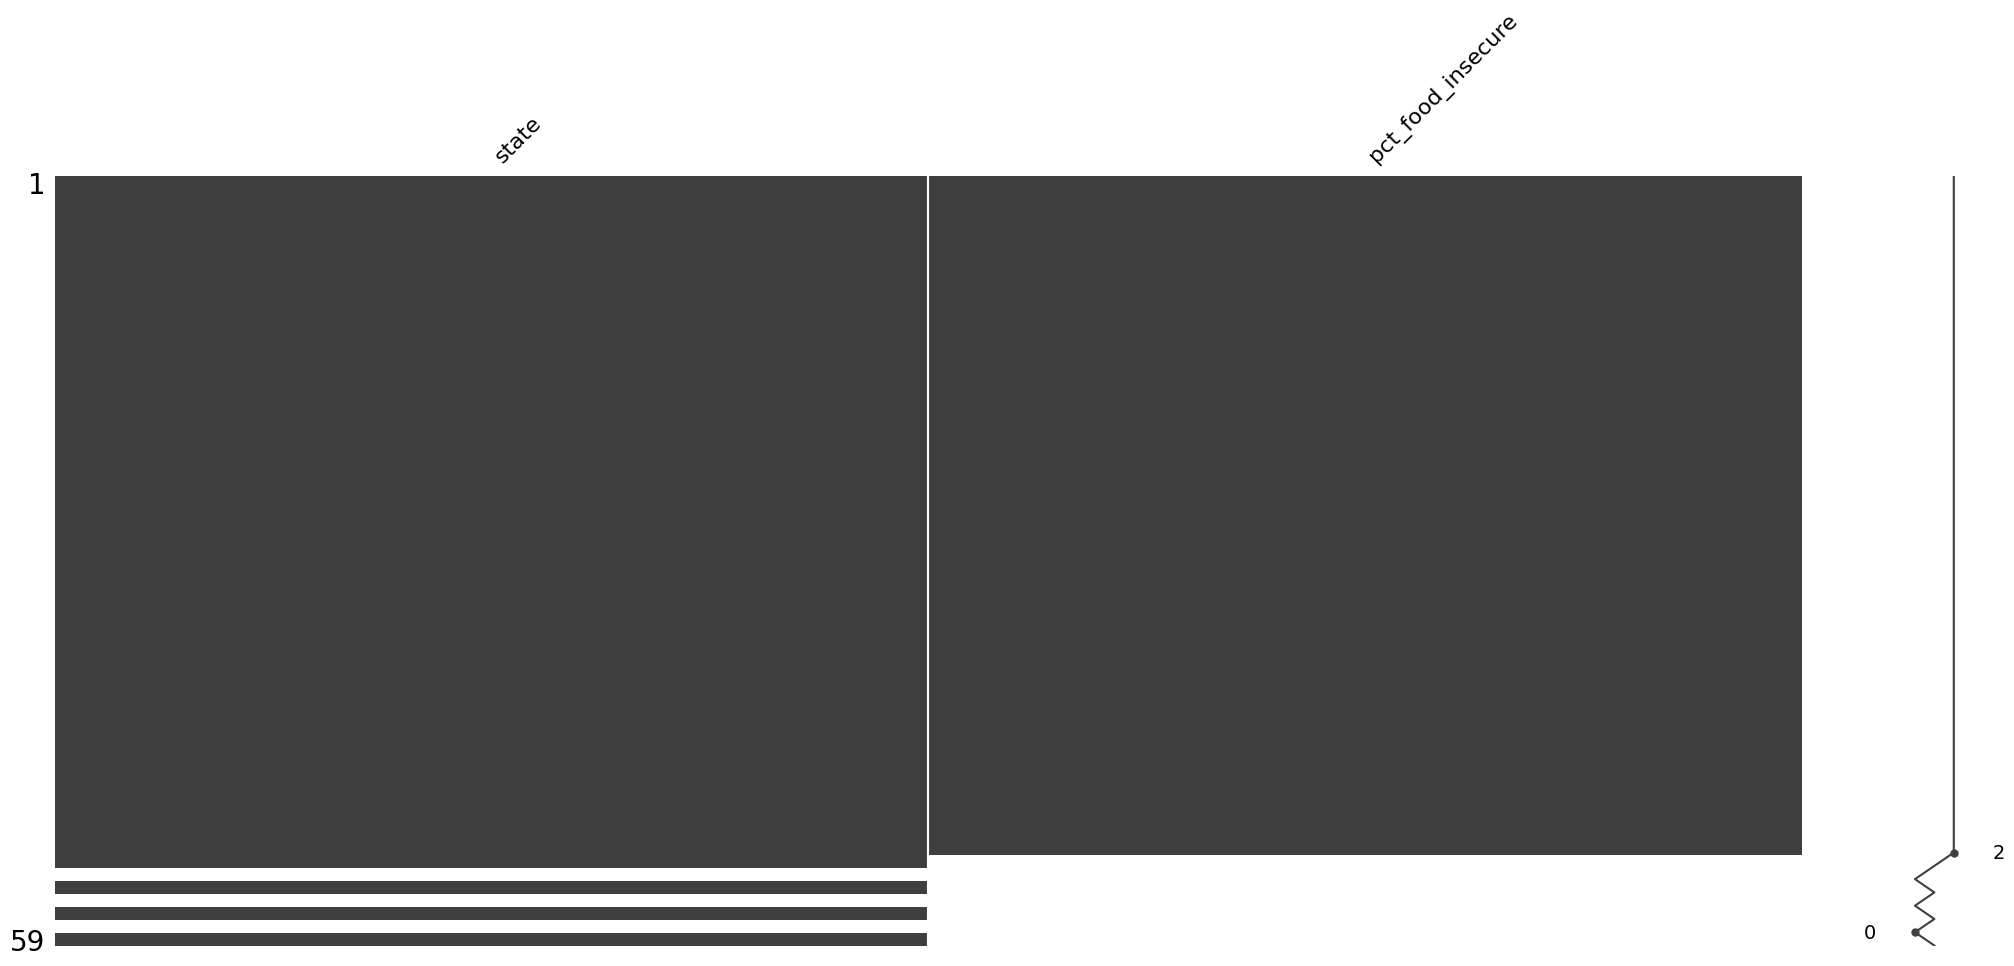

In [6]:
msno.matrix(df)

We can see that there are missing values in the "state" column

In [7]:
df[df.pct_food_insecure.isnull()]

,state,pct_food_insecure
52,*Difference from U.S. average was statisticall...,NaN
53,NaN,NaN
54,1Totals exclude households for which food secu...,NaN
55,NaN,NaN
56,2Margin of error with 90 percent confidence (1...,NaN
57,NaN,NaN
58,"Source: USDA, Economic Research Service using ...",NaN


In [8]:
df

,state,pct_food_insecure
0,U.S.,10.4
1,AK,9.5
2,AL,13.1
3,AR,15.0
4,AZ,10.1
5,CA,9.6
6,CO,10.5
7,CT,9.6
8,DC,9.0
9,DE,11.2


### We only want rows in which the length of the state value is 2 characters

In [9]:
df = df[df.state.str.len()==2]

now let's look at a histogram of pct_food_inscure values

<AxesSubplot: >

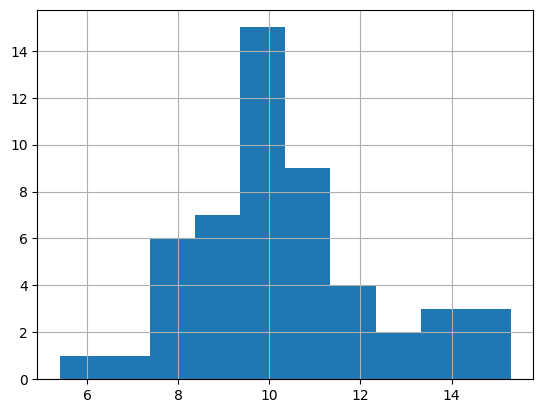

In [10]:
df.pct_food_insecure.hist()

no giant outliers and all the data seems reasonable

## Now let's get the geometries of US states.  
This comes to us in the form of a Shapefile, which is a folder containing each of the files necessary for Python to read and visualize geographic data about the states

We'll pull this from the US Census cartographic boundaries page:
https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [11]:
wget.download("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")

-1 / unknown

'cb_2018_us_state_500k.zip'

We have to unzip the result in the folder.  On a Mac that's as easy as double clicking the file.  Windows may require you to use decompression application.

# We'll use geopandas (gpd) to read in the shapefile folder
Note: we're giving it the reference for the folder rather than files inside the folder...geopandas knows where to find all that it needs inside the folder

In [12]:
gdf = gpd.read_file(os.getcwd()+'/cb_2018_us_state_500k')

In [13]:
gdf.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."


## Merge the hunger data with our new geopandas dataframe

We're going to merge "gdf" with "df" where "gdf" is left and the state abbreviation colum in that frame is "STUSPS"...and "df" is right and the state abbreviation column is "state"

In [14]:
gdf = gdf.merge(df,left_on='STUSPS',right_on='state')

We run into interesting issues when plotting the geopandas dataframe as-is...


<AxesSubplot: >

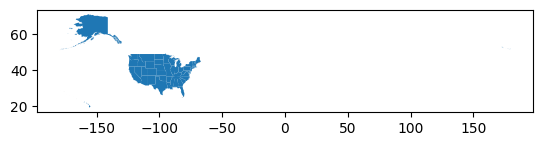

In [15]:
gdf.plot()

To make full use of the space available in our visualization, we're going to pull out Alaska and Hawaii and reproject them on the map just below the continental US

In [16]:
alaska_gdf = gdf[gdf.state=='AK']

In [17]:
hawaii_gdf = gdf[gdf.state=='HI']

Look at what happens when we visualize all of Alaska including the islands that cross over -180 degrees Longitude:

<AxesSubplot: >

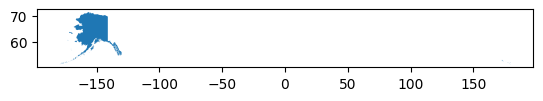

In [18]:
alaska_gdf.plot()

We'll need to clip Alaska to show just the main body of the state

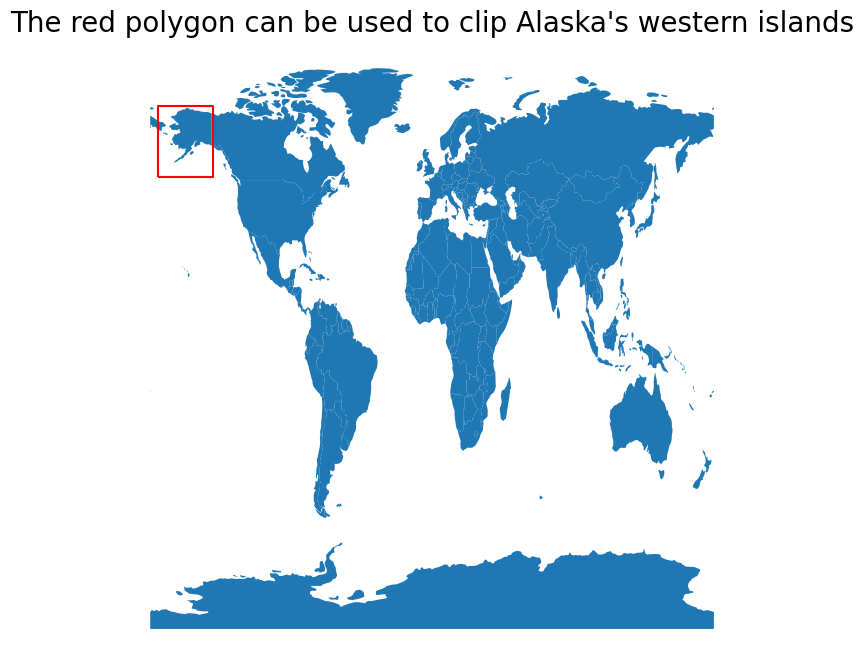

In [19]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))



# NOTE: the convention for polygon points is (Long, Lat)....counterintuitive
polygon = Polygon([(-175,50),(-175,72),(-140, 72),(-140,50)])
# polygon = Polygon([(-180,0),(-180,90),(-120,90),(-120,0)])

# polygon=hipolygon
poly_gdf = gpd.GeoDataFrame( geometry=[polygon], crs=world.crs)

fig, ax1 = plt.subplots(1, figsize=(8, 18))
world.plot(ax=ax1)
poly_gdf.boundary.plot(ax = ax1, color="red")
ax1.set_title("The red polygon can be used to clip Alaska's western islands", fontsize=20)
ax1.set_axis_off()
plt.show()


/Users/alex/geoVisual/lib/python3.8/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


<AxesSubplot: >

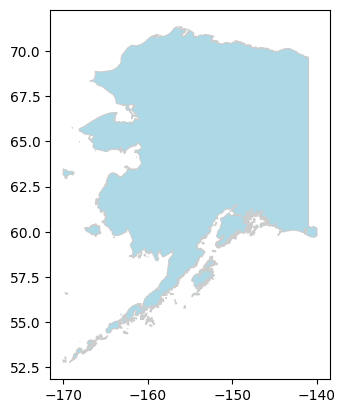

In [20]:
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
# apply1(alaska_gdf,0,36)
alaska_gdf.clip(polygon).plot( color='lightblue', linewidth=0.8, edgecolor='0.8')
# alaska_gdf.clip(polygon).plot(column=variable, cmap = colormap, linewidth=0.8,ax=akax, edgecolor='0.8')



We'll have a similar issue with Hawaii:

<AxesSubplot: >

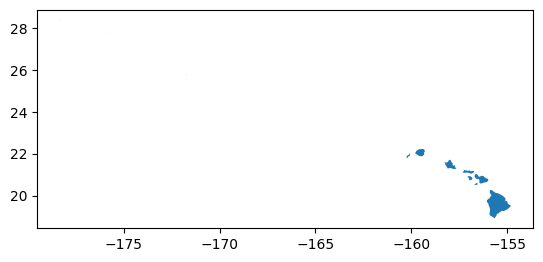

In [21]:
hawaii_gdf.plot()

We'll clip it with a polygon the same way:

<AxesSubplot: >

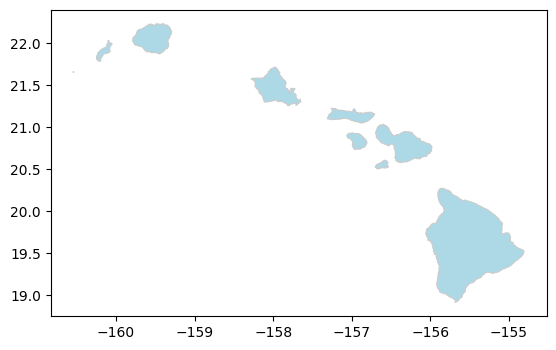

In [22]:
hipolygon = Polygon([(-161,0),(-161,90),(-120,90),(-120,0)])
hawaii_gdf.clip(hipolygon).plot(color='lightblue', linewidth=0.8, edgecolor='0.8')


## <b>A brief intro to projections</b>

Because the earth is round, projecting geography onto 2 dimensional maps requires some fancy math.  Fortunately, cartographers have helped take a lot of the pain out of this process.

Coordinate Reference Systems (CRS) help project lattitude and longitude coordinates onto 2-dimensional maps.  There are many different systems and each correspond to a different method of projection.  

Geopandas makes it easy to expereiment with different CRSs
https://geopandas.org/en/stable/docs/user_guide/projections.html

The European Petrolium Survey Group (EPSG)(https://epsg.org/home.html) maintains an extensive set of projections for cartographic applications.  The best projection for use in a particular visualization depends on the part of the world being visualized and the preferences of the developer.

A helpfull tool for choosing a CRS can be found here: https://epsg.io/

CRS selection can cause some land masses to look larger or smaller than they are relative to others.  There's always going to be a bit of distortion in a map.  Your job is to manage that.

Here's a good look at why this matters from Open News:
https://source.opennews.org/articles/choosing-right-map-projection/

![alt text](images/projections_from_OpenNews.jpg)

We can re-project coordinates for any of the components of our map using the geopandas command "to_crs":
"gdf = gdf.to_crs({'init':'epsg:2163'})"

## Note:
Once we re-project a dataframe with to_crs we change the geometry properties of the dataframe.  I find it best to create copies of the original datafarme and re-project them as needed (leaving the original gdf geometry unchanged).

## Managing Alaka and Hawaii

We're going to create new boxes to map them in underneath and to the left of the continental US.  Confusingly, these boxes are referred to as "axes" in matplotlib.

/Users/alex/geoVisual/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


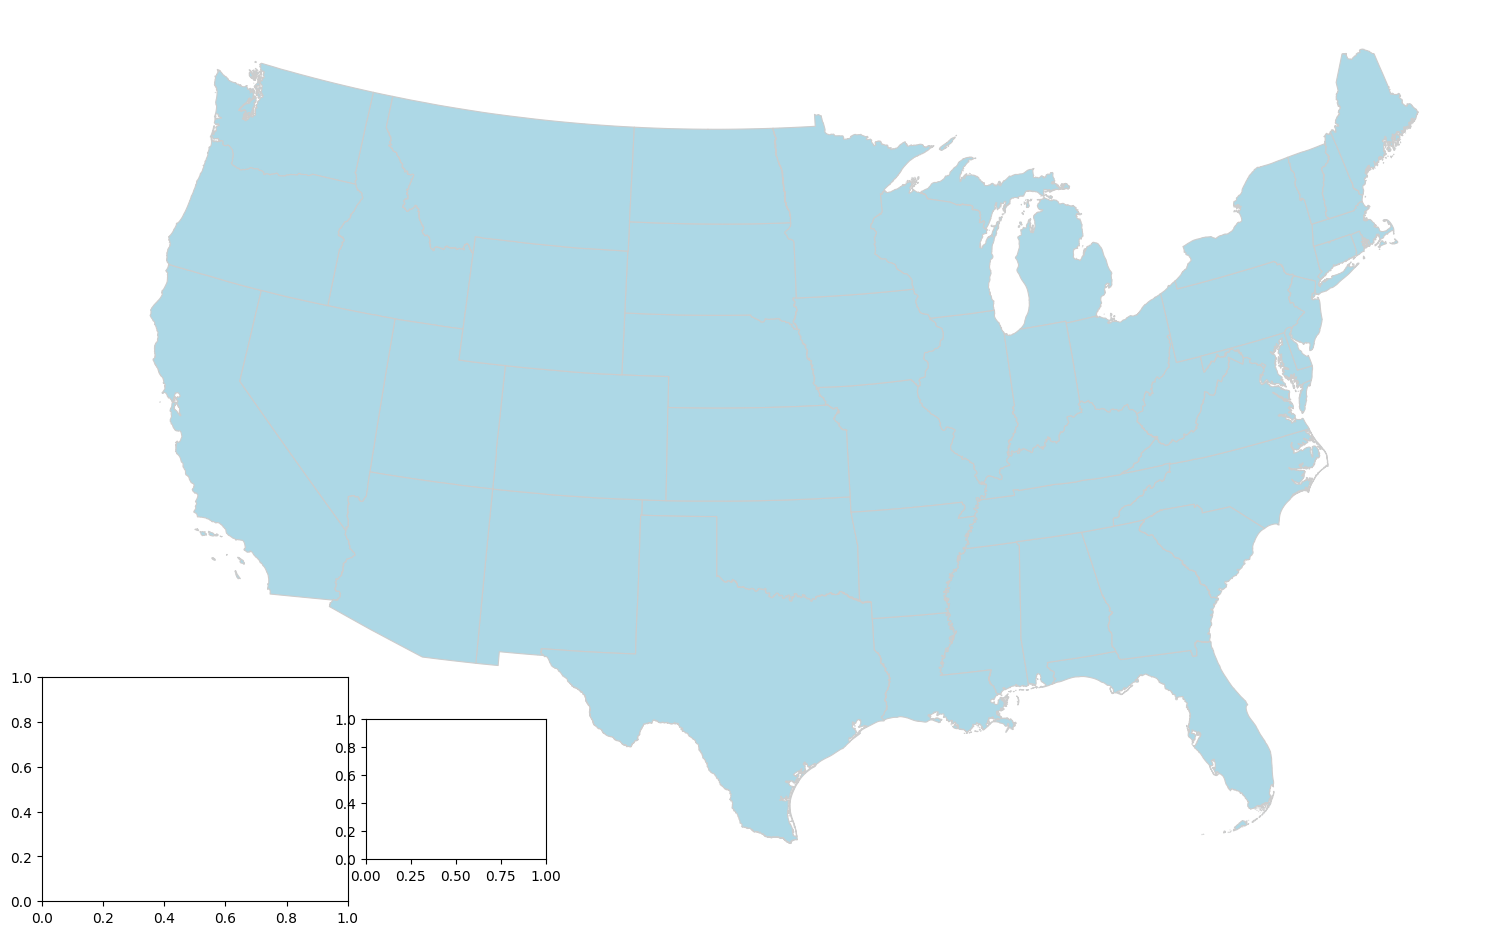

In [23]:
# Create a "copy" of gdf for re-projecting
visframe = gdf.to_crs({'init':'epsg:2163'})

# create figure and axes for with Matplotlib for main map
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box from the main map
ax.axis('off')


# create map of all states except AK and HI in the main map axis
visframe[~visframe.state.isin(['HI','AK'])].plot(color='lightblue', linewidth=0.8, ax=ax, edgecolor='0.8')


# Add Alaska Axis (x, y, width, height)
akax = fig.add_axes([0.1, 0.17, 0.17, 0.16])   


# Add Hawaii Axis(x, y, width, height)
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   

# We'll later map Alaska in "akax" and Hawaii in "hiax"


# Bringing it all together

Let's look at the distribution of percentage of food insecurity among states

In [24]:
gdf.pct_food_insecure.describe()

count    51.000000
mean     10.313725
std       2.105328
min       5.400000
25%       9.050000
50%      10.100000
75%      11.200000
max      15.300000
Name: pct_food_insecure, dtype: float64

The highest percentage is 15.3%.  We're going to want the color scale on our choropleth to go up to at least 16% for it to make sense

In [25]:
# Apply this to AK and HI... DO NOT use this for the rest of CONUS

def makeColorColumn(gdf,variable,vmin,vmax):
    # apply a function to a column to create a new column of assigned colors & return full frame
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrBr)
    gdf['value_determined_color'] = gdf[variable].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x)))
    return gdf

### Note:
The colormap "YlOrBr" is hard coded in the function above. 
It can be changed in the 2nd line of the funciton to any of the matplotlib cmaps

/Users/alex/geoVisual/lib/python3.8/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/alex/geoVisual/lib/python3.8/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/Users/alex/geoVisual/lib/python3.8/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


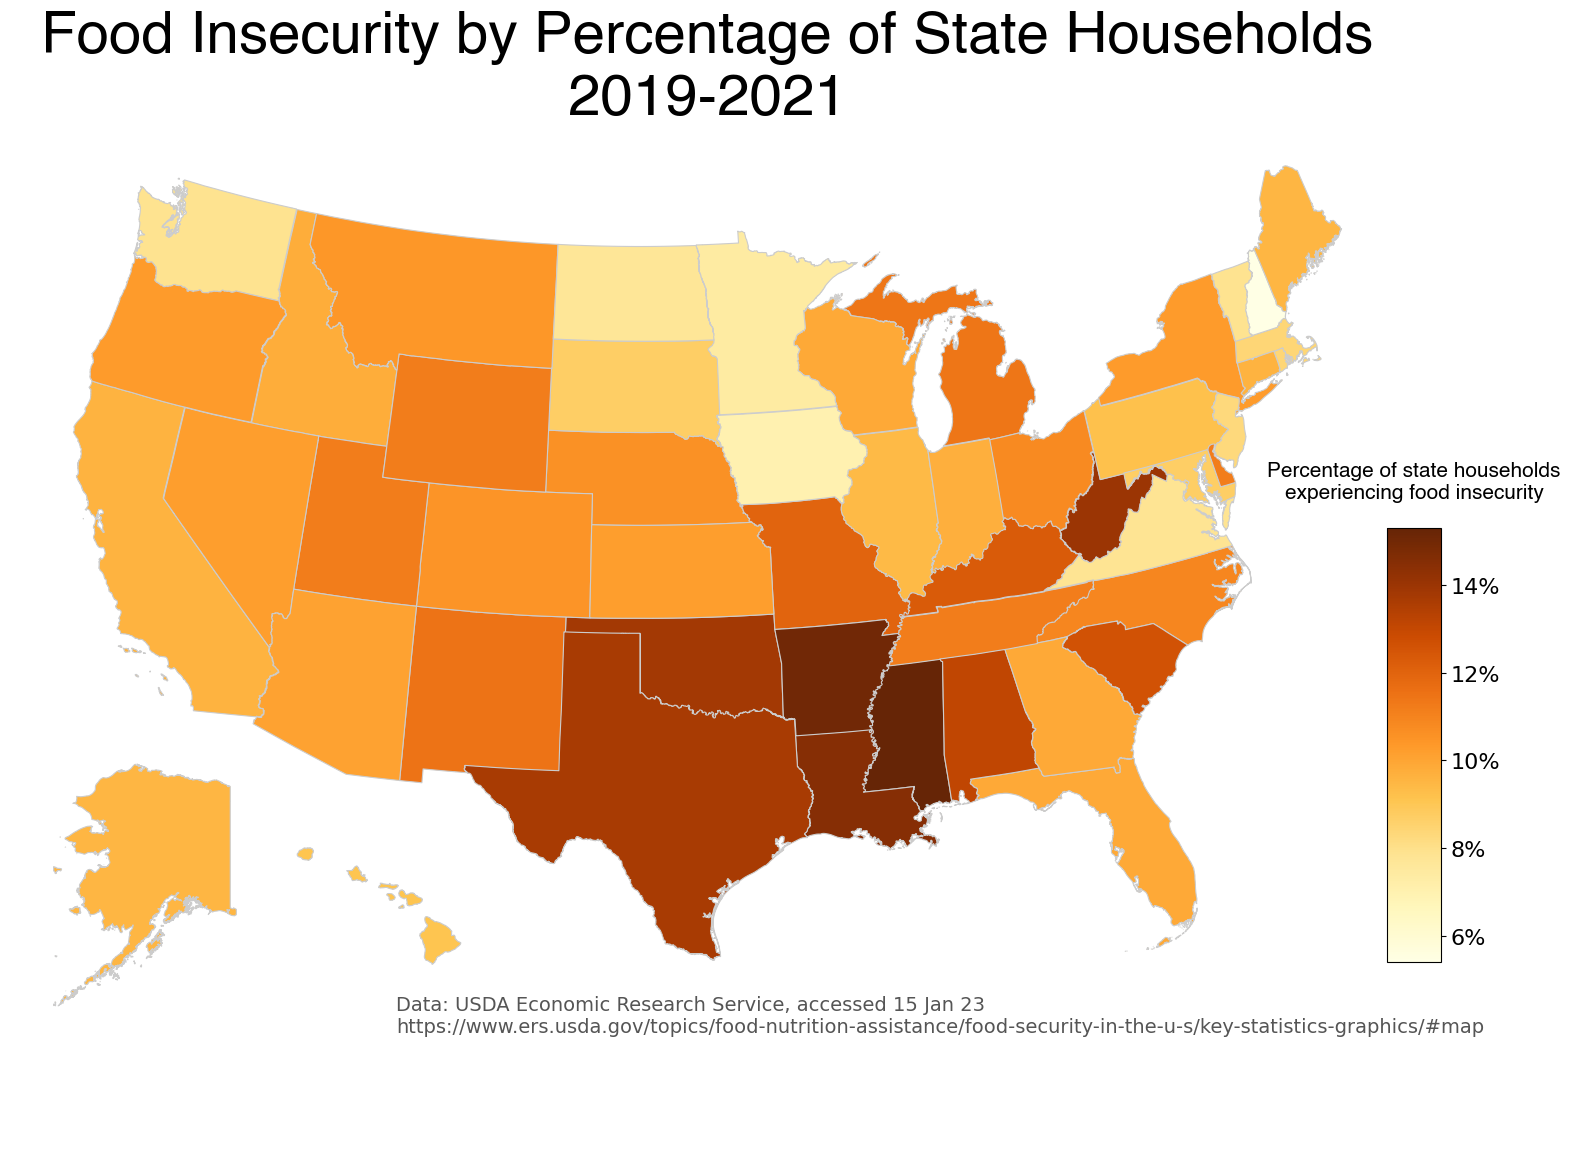

In [26]:
# **************************
# set the value column that will be visualised
variable = 'pct_food_insecure'

# make a column for value_determined_color in gdf
# set the range for the choropleth values with the upper bound the rounded up maximum value
vmin, vmax = gdf.pct_food_insecure.min(), gdf.pct_food_insecure.max() #math.ceil(gdf.pct_food_insecure.max())
# Choose the continuous colorscale "YlOrBr" from https://matplotlib.org/stable/tutorials/colors/colormaps.html
colormap = "YlOrBr"
gdf = makeColorColumn(gdf,variable,vmin,vmax)

# create "visframe" as a re-projected gdf using EPSG 2163
visframe = gdf.to_crs({'init':'epsg:2163'})



# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(18, 14))
# remove the axis box around the vis
ax.axis('off')

# set the font for the visualization to Helvetica
hfont = {'fontname':'Helvetica'}

# add a title and annotation
ax.set_title('Food Insecurity by Percentage of State Households\n2019-2021', **hfont, fontdict={'fontsize': '42', 'fontweight' : '1'})

# Create colorbar legend
fig = ax.get_figure()
# add colorbar axes to the figure
# This will take some iterating to get it where you want it [l,b,w,h] right
# l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
cbax = fig.add_axes([0.89, 0.21, 0.03, 0.31])   

cbax.set_title('Percentage of state households\nexperiencing food insecurity\n', **hfont, fontdict={'fontsize': '15', 'fontweight' : '0'})

# add color scale
sm = plt.cm.ScalarMappable(cmap=colormap, \
                 norm=plt.Normalize(vmin=vmin, vmax=vmax))
# reformat tick labels on legend
sm._A = []
comma_fmt = FuncFormatter(lambda x, p: format(x/100, '.0%'))
fig.colorbar(sm, cax=cbax, format=comma_fmt)
tick_font_size = 16
cbax.tick_params(labelsize=tick_font_size)
ax.annotate("Data: USDA Economic Research Service, accessed 15 Jan 23\nhttps://www.ers.usda.gov/topics/food-nutrition-assistance/food-security-in-the-u-s/key-statistics-graphics/#map", xy=(0.22, .085), xycoords='figure fraction', fontsize=14, color='#555555')


# create map
# Note: we're going state by state here because of unusual coloring behavior when trying to plot the entire dataframe using the "value_determined_color" column
for row in visframe.itertuples():
    if row.state not in ['AK','HI']:
        vf = visframe[visframe.state==row.state]
        c = gdf[gdf.state==row.state][0:1].value_determined_color.item()
        vf.plot(color=c, linewidth=0.8, ax=ax, edgecolor='0.8')



# add Alaska
akax = fig.add_axes([0.1, 0.17, 0.2, 0.19])   
akax.axis('off')
# polygon to clip western islands
polygon = Polygon([(-170,50),(-170,72),(-140, 72),(-140,50)])
alaska_gdf = gdf[gdf.state=='AK']
alaska_gdf.clip(polygon).plot(color=gdf[gdf.state=='AK'].value_determined_color, linewidth=0.8,ax=akax, edgecolor='0.8')


# add Hawaii
hiax = fig.add_axes([.28, 0.20, 0.1, 0.1])   
hiax.axis('off')
# polygon to clip western islands
hipolygon = Polygon([(-160,0),(-160,90),(-120,90),(-120,0)])
hawaii_gdf = gdf[gdf.state=='HI']
hawaii_gdf.clip(hipolygon).plot(column=variable, color=hawaii_gdf['value_determined_color'], linewidth=0.8,ax=hiax, edgecolor='0.8')



fig.savefig(os.getcwd()+'/food_insecurity_by_state_2019_2021.png',dpi=400, bbox_inches="tight")
# bbox_inches="tight" keeps the vis from getting cut off at the edges in the saved png
# dip is "dots per inch" and controls image quality.  Many scientific journals have specifications for this
# https://stackoverflow.com/questions/16183462/saving-images-in-python-at-a-very-high-quality





# <b>Does this make sense?</b>
Let's pick states with similar values and make sure they're similar colors on the choropleth

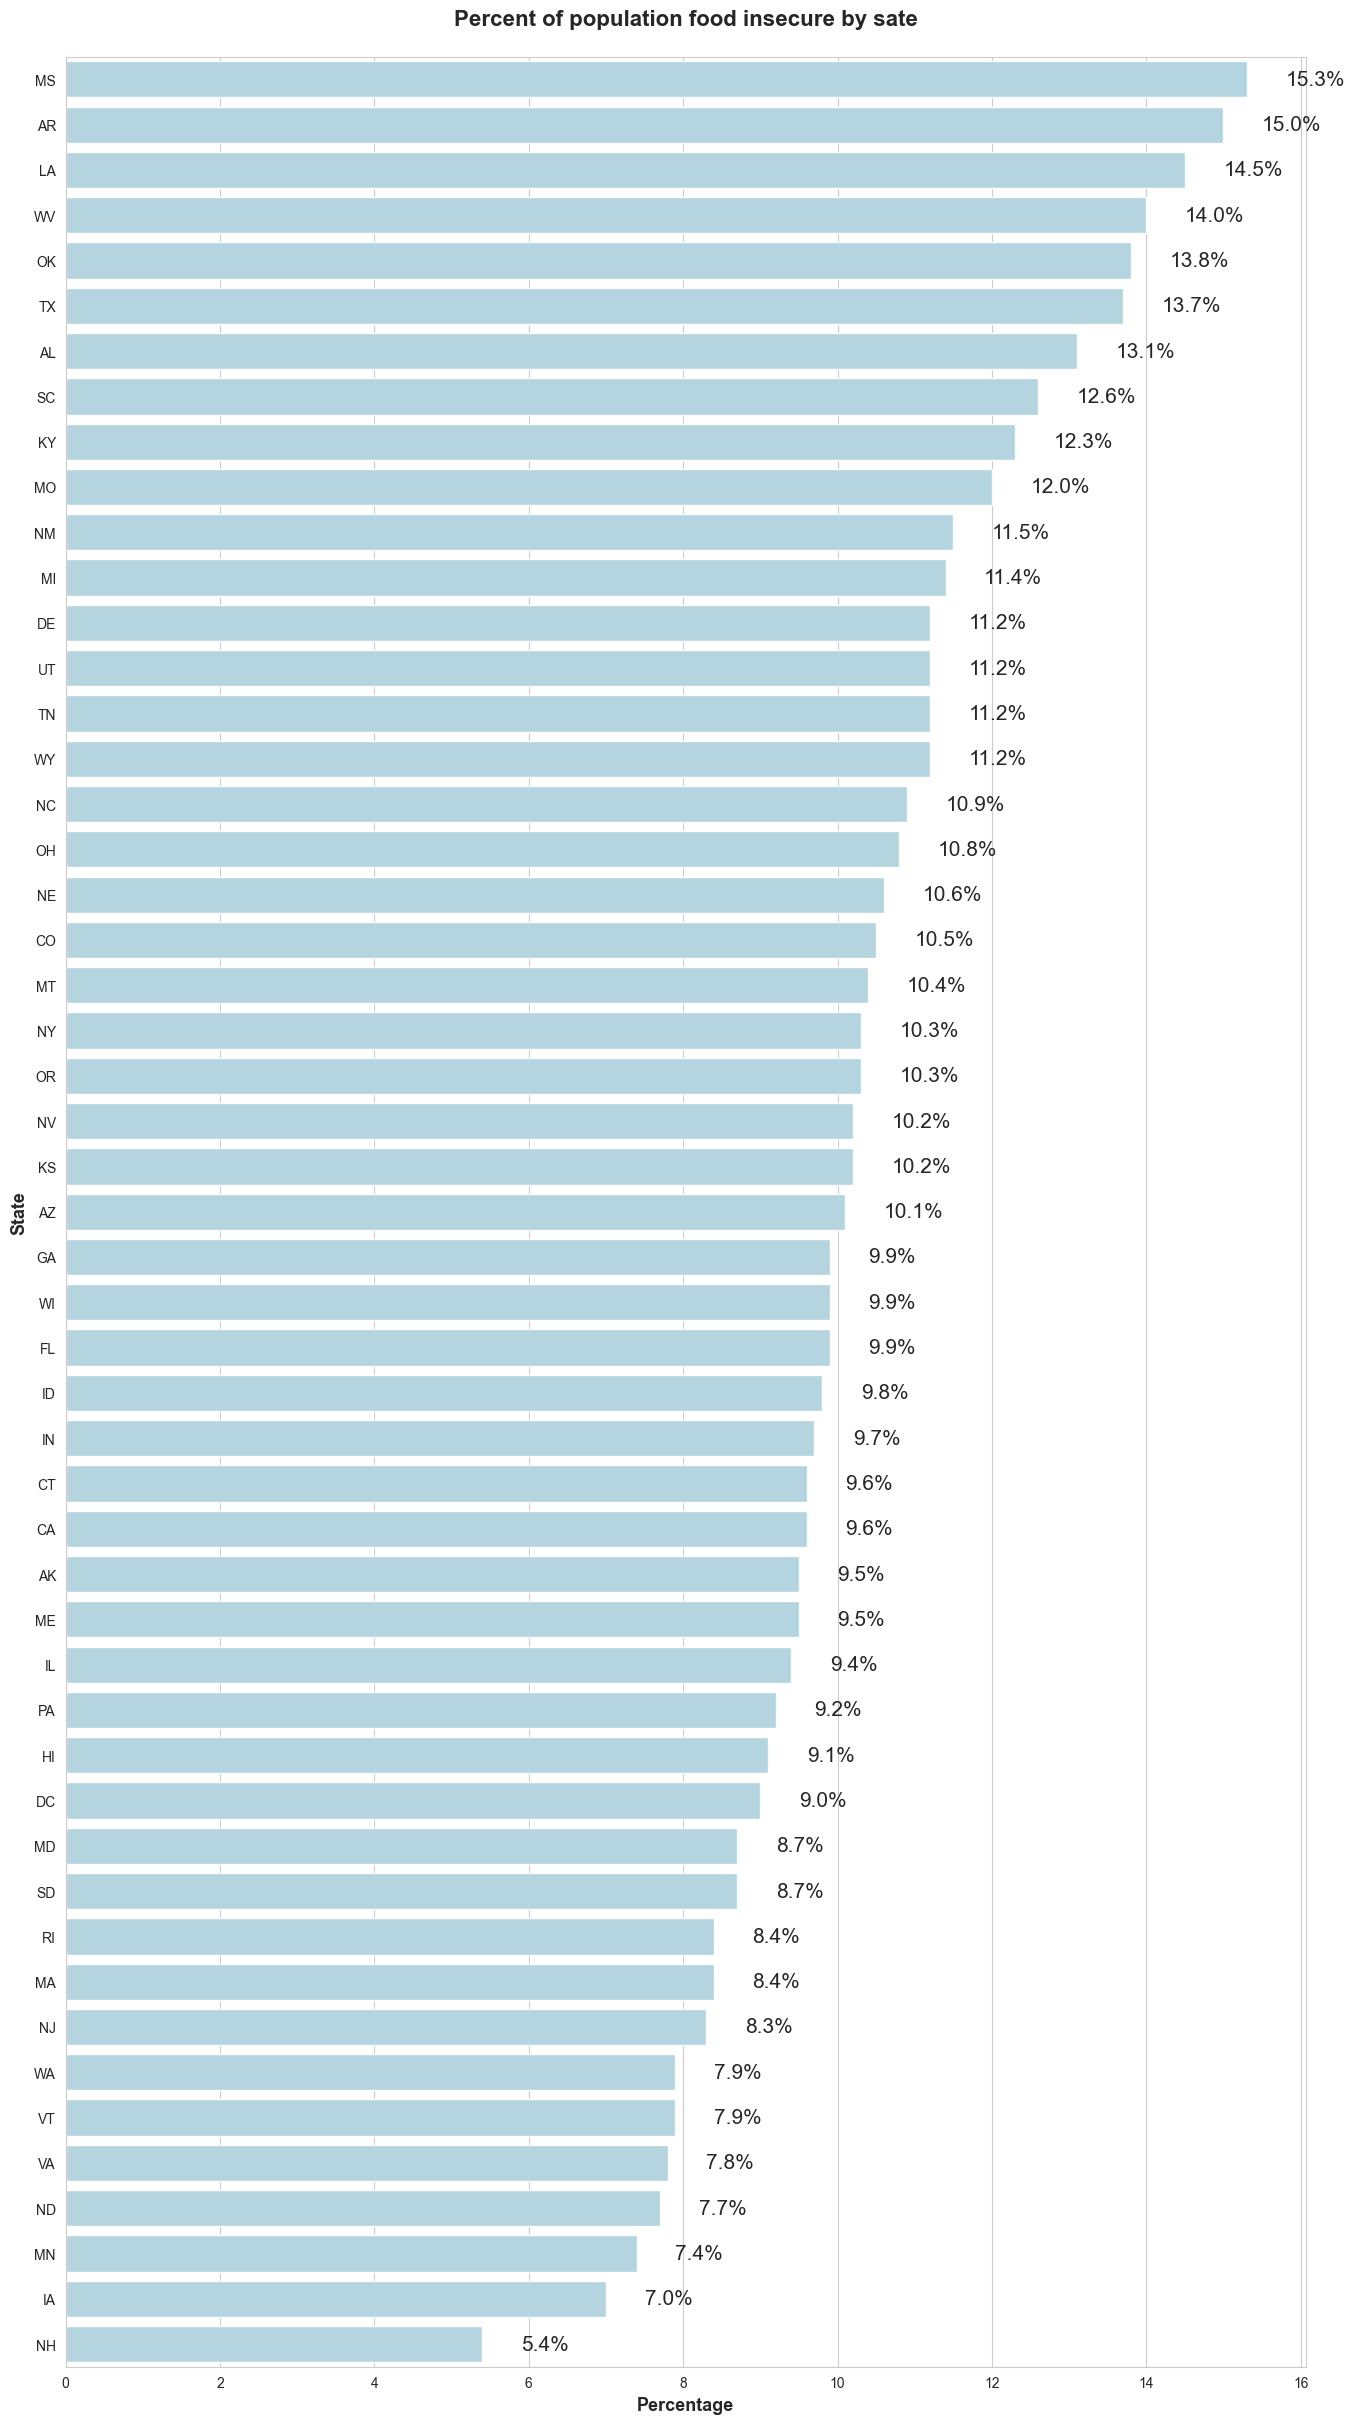

In [27]:


visFrame = gdf.sort_values('pct_food_insecure',ascending=False)[:100]


#Horizontal barchart
#Create subplot
sns.set_style('whitegrid') #set theme
fig,ax=plt.subplots(figsize=(16,30))
#Create barplot
################################################################ ***** "palette" for colors...
chart1 = sns.barplot(x=visFrame['pct_food_insecure'],y=visFrame['state'],color='lightblue')
chart1.set_title('Percent of population food insecure by sate\n',weight='bold',fontsize=16)

chart1.set_xlabel('Percentage',weight='bold',fontsize=13)
chart1.set_ylabel('State', weight='bold',fontsize=13)
#Value number on chart: from "max" on stackoverflow https://stackoverflow.com/questions/49820549/labeling-horizontal-barplot-with-values-in-seaborn 
for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + .5,       # set the text at .5 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:}%'.format(round(width,1)), # set variable to display
            fontsize=15,
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

Maine and Alaska are both 9.5% food insecure

In [28]:
gdf[gdf.state.isin(['ME','AK'])][['state','pct_food_insecure','value_determined_color']]

,state,pct_food_insecure,value_determined_color
26,AK,9.5,#feb643
38,ME,9.5,#feb643


The algorithm gave both the same color

![alt text](images/maine_color.png)
![alt text](images/alaska_color.png)

The map plots both as the same color. We're good!

# <b> Acknowledgements</b>
This notebook is the product of a lot of time reading documentation, googling, and exploring.  I haven't been able to record all of the articles, posts, and stack overflow handles that provided useful inputs or perspectives.

Abdishakur on Medium https://medium.com/@shakasom has been a big influence on my work.  I highly recommend following him.

I got my start in Python programming almost a decade ago when I finally couldn't stand manualy scheduling all of the flights for my Air Force squadron anymore.  Sentdex's youtube channel made Python acccessible, practical, and fun for me when I new just about nothing about coding (https://www.youtube.com/@sentdex).  Harrison was among the most influential educators in my life, though I've never met him or spoken with him.

Both US Census and USDA make an amazing amount of data publicly available and have created an environment where open source tools can thrive.  Both websites are worth a deep dive when you have the time.

### Questions/Comments/Feedback?

alexrich@duck.com
